<a href="https://colab.research.google.com/github/azzindani/02_Deep_Learning_ANN/blob/main/DL_Multiple_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version 20240820

## 00 Importing Modules & Mounting Drive

In [1]:
!pip install ydata-profiling

import pathlib
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import numpy as np
import pandas as pd
import sklearn
import pickle
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
import tensorflow as tf
import datetime as dt

from scipy import stats as sm
from IPython.display import Image
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, accuracy_score, average_precision_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from ydata_profiling import ProfileReport
from tabulate import tabulate
from tensorflow.keras import layers, losses, initializers, Model, regularizers, activations

%matplotlib inline

In [2]:
'''from google.colab import drive
drive.mount('/content/drive') #'''

"from google.colab import drive\ndrive.mount('/content/drive') #"

In [3]:
'''MAIN_PATH = str(pathlib.Path().resolve())
WORK_PATH = MAIN_PATH + '/drive/MyDrive/Workspace'
SOURCE_PATH = WORK_PATH + '/00_Data_Source'
CACHE_PATH = WORK_PATH + '/00_Cache_Data' #'''

"MAIN_PATH = str(pathlib.Path().resolve())\nWORK_PATH = MAIN_PATH + '/drive/MyDrive/Workspace'\nSOURCE_PATH = WORK_PATH + '/00_Data_Source'\nCACHE_PATH = WORK_PATH + '/00_Cache_Data' #"

## 01 Choosing & Importing Dataset

### 01.00 Importing Data from Zipfile

In [4]:
'''filename = 'Diseases_And_Symptoms.zip' # replace this

url = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename
http_response = urlopen(url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall() #'''

"filename = 'Diseases_And_Symptoms.zip' # replace this\n\nurl = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename\nhttp_response = urlopen(url)\nzipfile = ZipFile(BytesIO(http_response.read()))\nzipfile.extractall() #"

In [5]:
os.listdir()

['.config', 'sample_data']

In [6]:
'''df = pd.read_csv(os.listdir()[1], encoding = 'ISO-8859-1')#, sep = ';')
df.shape #'''

"df = pd.read_csv(os.listdir()[1], encoding = 'ISO-8859-1')#, sep = ';')\ndf.shape #"

### 01.01 Importing Main Data

In [7]:
filename = 'Multiple_Disease_Prediction.csv' # replace this

url = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename
df = pd.read_csv(url, encoding = 'ISO-8859-1')#, sep = ';')
df.shape #'''

(2351, 25)

In [8]:
df.nunique()

,0
Glucose,65
Cholesterol,65
Hemoglobin,65
Platelets,65
White Blood Cells,65
Red Blood Cells,65
Hematocrit,65
Mean Corpuscular Volume,65
Mean Corpuscular Hemoglobin,65
Mean Corpuscular Hemoglobin Concentration,65


In [9]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [11]:
for column in df.columns:
  if df[column].dtypes == 'object':
    print(column)
    print('-' * 100)
    print(df[column].unique())
    print('=' * 100)

Disease
----------------------------------------------------------------------------------------------------
['Healthy' 'Diabetes' 'Thalasse' 'Anemia' 'Thromboc']


### 01.02 Importing Geo Data

In [12]:
'''geo_path = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json' # replace this

gdf = gpd.read_file(geo_path)
gdf.head(2) #'''

"geo_path = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json' # replace this\n\ngdf = gpd.read_file(geo_path)\ngdf.head(2) #"

In [13]:
'''gdf = gdf.rename(columns = {'name' : 'State'})
gdf = gdf[['State', 'geometry']]
gdf.head(2) #'''

"gdf = gdf.rename(columns = {'name' : 'State'})\ngdf = gdf[['State', 'geometry']]\ngdf.head(2) #"

### 01.03 Importing Additional Data (for enrichment)

### 01.04 Dataframe Back Up

In [14]:
df_bu = df.copy()

## 02 Data Structuring

### 02.01 Selecting & Dropping Variables

In [15]:
column_list = [] # fill this

df = df.drop(column_list, axis = 1)
df.head(2) #'''

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


### 02.02 Cleaning Text Object

#### 02.02.01 Convert Header to Proper Text

In [16]:
'''for x in df.columns:
  y = x.title()
  df = df.rename(columns = {x : y}) #'''

'for x in df.columns:\n  y = x.title()\n  df = df.rename(columns = {x : y}) #'

#### 02.02.02 Strip Abnormal Spaces

In [17]:
'''for x in df.columns:
  if df[x].dtypes == 'object':
    try:
      df[x] = df[x].str.strip()
    except:
      pass #'''

"for x in df.columns:\n  if df[x].dtypes == 'object':\n    try:\n      df[x] = df[x].str.strip()\n    except:\n      pass #"

#### 02.02.03 Convert Object Content to Proper Text

In [18]:
'''for x in df.columns:
  if df[x].dtypes == 'object':
    for a in df[x].unique():
      b = a.title()
      df[x] = df[x].replace(a, b)
  else:
    pass #'''

"for x in df.columns:\n  if df[x].dtypes == 'object':\n    for a in df[x].unique():\n      b = a.title()\n      df[x] = df[x].replace(a, b)\n  else:\n    pass #"

### 02.03 Coverting Data

#### 02.03.01 Convert to date

In [19]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [20]:
column_list = ['Activity Period Start Date'] # fill this

for x in column_list:
  try:
    df[x] = pd.to_datetime(df[x])
  except:
    pass #'''

#### 02.03.02 Convert to integer

In [21]:
column_list = [] # fill this

for x in column_list:
  df[x] = df[x].astype('int') #'''

#### 02.03.03 Convert to Object (if necessary)

In [22]:
column_list = [] # fill this

for x in column_list:
  df[x] = df[x].astype('str') #'''

#### 02.03.04 Replace 0 to Nan (if necessary)

In [23]:
#df = df.replace(0, np.nan)

#### 02.03.05 Filling 0 to Nan

In [24]:
'''for column in df.columns:
  if df[column].dtype == 'float64' or df[column].dtype == 'int64':
    df[column] = df[column].fillna(0)
    print(column)
  else:
    pass #'''

"for column in df.columns:\n  if df[column].dtype == 'float64' or df[column].dtype == 'int64':\n    df[column] = df[column].fillna(0)\n    print(column)\n  else:\n    pass #"

#### 02.03.06 Dropping Nan

In [25]:
#df = df.dropna()

## 03 Data Cleaning

### 03.01 Replacing Variable Component

In [26]:
'''value_dict = {} # fill this

column_name = ''

df[column_name] = df[column_name].replace(value_dict) #'''

"value_dict = {} # fill this\n\ncolumn_name = ''\n\ndf[column_name] = df[column_name].replace(value_dict) #"

### 03.02 Add New Variable

#### 03.02.01 Add by Math Calculation

In [27]:
'''new_var = '' # fill this
obj_var1 = '' # fill this
obj_var2 = '' # fill this

df[new_var] = df[obj_var1] * df [obj_var2] #'''

"new_var = '' # fill this\nobj_var1 = '' # fill this\nobj_var2 = '' # fill this\n\ndf[new_var] = df[obj_var1] * df [obj_var2] #"

#### 03.02.02 Add by Replacing "Other"

In [28]:
'''column_name = '' # fill this

df[column_name].value_counts() #'''

"column_name = '' # fill this\n\ndf[column_name].value_counts() #"

In [29]:
'''value_thres = 1300

replace_list = []

df_dict = df[column_name].value_counts().to_dict()
for i in df_dict:
  if df_dict[i] < value_thres:
    replace_list.append(i)

replace_list #'''

'value_thres = 1300\n\nreplace_list = []\n\ndf_dict = df[column_name].value_counts().to_dict()\nfor i in df_dict:\n  if df_dict[i] < value_thres:\n    replace_list.append(i)\n\nreplace_list #'

In [30]:
'''df[column_name] = df[column_name].copy().replace(to_replace = replace_list, value = 'Other') #'''

"df[column_name] = df[column_name].copy().replace(to_replace = replace_list, value = 'Other') #"

### 03.03 Inaccuracies

In [31]:
column_list = [] # fill this

for x in column_list:
  try:
    df[x] = df[x].replace('0', np.nan)
    df = df.dropna()
  except:
    pass

### 03.04 Handling

##### Data Distribution Check (Before)

In [32]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [34]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.histogram(
  df,
  x = x,
  y = y,
  color = color,
  marginal = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.histogram(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

In [35]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.scatter(
  df,
  x = x,
  y = y,
  color = color,
  marginal_x = 'histogram',
  marginal_y = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.scatter(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal_x = 'histogram',\n  marginal_y = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

#### 03.04.01 Using IQR (Inter Quantile Range)

In [36]:
def iqr_thres(dataframe, column, th1 = 0.25, th3 = 0.75):
  quartile1 = dataframe[column].quantile(th1)
  quartile3 = dataframe[column].quantile(th3)
  iqr = quartile3 - quartile1
  upper_limit = quartile3 + 1.5 * iqr
  lower_limit = quartile1 - 1.5 * iqr

  return lower_limit, upper_limit

In [37]:
def check_outliers_iqr(dataframe, column):
  lower_limit, upper_limit = iqr_thres(dataframe, column)
  if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis = None):
    return True
  else:
    return False

In [38]:
def replace_iqr(dataframe, columns, th1 = 0.25, th3 = 0.75, replace = False):
  data = []

  for column in columns:
    if dataframe[column].dtypes == 'int64' or dataframe[column].dtypes == 'float64':
      if column != 'Outcome':
        outliers_ = check_outliers_iqr(dataframe, column)
        count = None
        lower_limit, upper_limit = iqr_thres(dataframe, column, th1, th3)

        if outliers_:
          count = dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)][column].count()
          if replace:
            if lower_limit < 0:
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
            else:
              dataframe.loc[(dataframe[column] < lower_limit), column] = np.nan
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
        outliers_status = check_outliers_iqr(dataframe, column)
        data.append([outliers_, outliers_status, count, column, lower_limit, upper_limit ])

  table = tabulate(data, headers = ['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt = 'rst', numalign = 'right')
  print('Removing Outliers using IQR')
  print(table)

In [39]:
column_list = [] # fill this

replace_iqr(
  dataframe = df,
  columns = column_list,
  replace = True
)
df = df.dropna()#'''

Removing Outliers using IQR
=======================  ==========  =======  ========  =============  =============
Outliers (Previously)    Outliers    Count    Column    Lower Limit    Upper Limit
=======================  ==========  =======  ========  =============  =============
=======================  ==========  =======  ========  =============  =============


#### 03.04.02 Using Standard Deviation

In [40]:
def std_thres(dataframe, column):
  upper_limit = dataframe[column].mean() + 3 * dataframe[column].std()
  lower_limit = dataframe[column].mean() - 3 * dataframe[column].std()

  return lower_limit, upper_limit

In [41]:
def check_outliers_std(dataframe, column):
  lower_limit, upper_limit = std_thres(dataframe, column)
  if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis = None):
    return True
  else:
    return False

In [42]:
def replace_std(dataframe, columns, replace = False):
  data = []

  for column in columns:
    if dataframe[column].dtypes == 'int64' or dataframe[column].dtypes == 'float64':
      if column != 'Outcome':
        outliers_ = check_outliers_std(dataframe, column)
        count = None
        lower_limit, upper_limit = std_thres(dataframe, column)

        if outliers_:
          count = dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)][column].count()
          if replace:
            if lower_limit < 0:
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
            else:
              dataframe.loc[(dataframe[column] < lower_limit), column] = np.nan
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
        outliers_status = check_outliers_std(dataframe, column)
        data.append([outliers_, outliers_status, count, column, lower_limit, upper_limit])

  table = tabulate(data, headers = ['Outlier (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt = 'rst', numalign = 'right')
  print('Removing Outliers using 3 Standard Deviation')
  print(table)

In [43]:
column_list = [] # fill this

replace_std(
  dataframe = df,
  columns = column_list,
  replace = True
)
df = df.dropna()#'''

Removing Outliers using 3 Standard Deviation
======================  ==========  =======  ========  =============  =============
Outlier (Previously)    Outliers    Count    Column    Lower Limit    Upper Limit
======================  ==========  =======  ========  =============  =============
======================  ==========  =======  ========  =============  =============


### 03.05 Handling Missing / Zeros / Null
##### Filling missing value (numerical only) is better using median than mean or mode

#### 03.05.01 Detecting Zero Value

In [44]:
zero_columns = [] # fill this

for x in df.columns:
  if df[x].dtypes == 'int64' or df[x].dtypes == 'float64':
    if (df[x] == 0).sum() != 0:
      print(x, ':', str((df[x] == 0).sum()))
      zero_columns.append(x)

zero_columns #'''

[]

#### 03.05.02 Detecting Nan / Non Available Value

In [45]:
nan_columns = [] # fill this

for x in df.columns:
  if df[x].dtypes == 'object':
    if (df[x] == np.nan).sum() or (df[x] == '-').sum() != 0:
      print(x, ':', str((df[x] == np.nan).sum()))
      nan_columns.append(x)

nan_columns #'''

[]

#### 03.05.03 Replacing Zero with Mean (for numerical value if median value == 0), if necessary

In [46]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].mean()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].mean()) #'

#### 03.05.04 Replacing Zero with Median (for numerical value if median value != 0), if necessary

In [47]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].median()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].median()) #'

#### 03.05.05 Replacing Zero with Mode (for categorical / object value), if necessary

In [48]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].mode()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].mode()) #'

### 03.06 Handling Incomplete Data

### 03.07 Handling Data Biases

### 03.08 Handling Duplicates

In [49]:
#df = df.drop_duplicates()

##### Data Distribution Check (After)

In [50]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.histogram(
  df,
  x = x,
  y = y,
  color = color,
  marginal = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.histogram(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

In [51]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.scatter(
  df,
  x = x,
  y = y,
  color = color,
  marginal_x = 'histogram',
  marginal_y = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.scatter(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal_x = 'histogram',\n  marginal_y = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

## 04 Enriching Data
#### take other dataset, inside or outside from related dataset / business

In [52]:
'''location = 'Country' # replace this

a = df[location].unique()
b = gdf[location].unique()

for i in a:
  if i not in b:
    print(i)

print(50 * '=')

for i in b:
  if i not in a:
    print(i) #'''

"location = 'Country' # replace this\n\na = df[location].unique()\nb = gdf[location].unique()\n\nfor i in a:\n  if i not in b:\n    print(i)\n\nprint(50 * '=')\n\nfor i in b:\n  if i not in a:\n    print(i) #"

In [53]:
value_dict = {}

try:
  df[location] = df[location].replace(value_dict)
except:
  pass #'''

## 05 Data Validation
#### Verifying consistency, quality, and security of data

## 06 Exploration Data Analysis (Univariate)

In [54]:
'''data_profile = ProfileReport(
  df,
  correlations = {
    'pearson' : {'calculate' : True},
    'spearman' : {'calculate' : True},
    'kendall' : {'calculate' : True},
    'phi_k' : {'calculate' : True},
    'cramers': {'calculate' : True},
  },
)

data_profile #'''

"data_profile = ProfileReport(\n  df,\n  correlations = {\n    'pearson' : {'calculate' : True},\n    'spearman' : {'calculate' : True},\n    'kendall' : {'calculate' : True},\n    'phi_k' : {'calculate' : True},\n    'cramers': {'calculate' : True},\n  },\n)\n\ndata_profile #"

## 07 Select Variable X & Y | Splitting Data

#### 07.01 Data Balancing

In [55]:
'''# Check Before Data Balancing
y_var = 'HeartDisease'

fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in df[y_var].value_counts()]
labels = list(df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show() #'''

"# Check Before Data Balancing\ny_var = 'HeartDisease'\n\nfig, ax = plt.subplots(figsize = (5, 5))\nsizes = [count for count in df[y_var].value_counts()]\nlabels = list(df[y_var].value_counts().index)\n\nax.pie(\n  x = sizes,\n  labels = labels,\n  autopct = '%1.1f%%',\n)\nplt.show() #"

In [56]:
'''n = 20000
append_data = []

for i in df[y_var].unique():
  df_x = df[df[y_var] == i][:n]
  append_data.append(df_x)

append_df = pd.concat(append_data)
append_df.shape #'''

'n = 20000\nappend_data = []\n\nfor i in df[y_var].unique():\n  df_x = df[df[y_var] == i][:n]\n  append_data.append(df_x)\n\nappend_df = pd.concat(append_data)\nappend_df.shape #'

In [57]:
'''# Check After Data Balancing

fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in append_df[y_var].value_counts()]
labels = list(append_df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show() #'''

"# Check After Data Balancing\n\nfig, ax = plt.subplots(figsize = (5, 5))\nsizes = [count for count in append_df[y_var].value_counts()]\nlabels = list(append_df[y_var].value_counts().index)\n\nax.pie(\n  x = sizes,\n  labels = labels,\n  autopct = '%1.1f%%',\n)\nplt.show() #"

In [58]:
#df = append_df

### 07.02 Label Encoding / One Hot Encoding

#### 07.02.01 First Method

In [59]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [61]:
y_var = 'Disease'

class_dict = {}
count = 0
for cat in df[y_var].unique():
  class_dict[cat] = count
  count = count + 1

class_dict #'''

{'Healthy': 0, 'Diabetes': 1, 'Thalasse': 2, 'Anemia': 3, 'Thromboc': 4}

In [62]:
rev_class_dict = {v: k for k, v in class_dict.items()}

In [63]:
df[y_var] = df[y_var].replace(class_dict)

#### 07.02.02 Second Method

In [64]:
columns = [] # fill selected columns

for column in columns:
  df[column] = df[column].astype('str')
  print(df[column].unique())

In [65]:
label_encoders = {}

for column in columns:
  le = LabelEncoder()
  df[column] = le.fit_transform(df[column])
  label_encoders[column] = le

for column in columns:
  labels = label_encoders[column].classes_
  print(column)
  print('-' * 50)
  for i in range(len(labels)):
    print(str(i), ':', labels[i])
  print('=' * 50)

### 07.03 Define X & Y variables

In [66]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,0
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,1


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [68]:
#x_var = []
x_var = df.columns[1:]
y_var = 'Disease'

x = df[x_var]
y = df[y_var]

sel_var = y_var + x_var
#df = df[sel_var]
x.head(2)

,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,Insulin,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,0.034129,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,0
1,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,0.571162,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,1


In [69]:
x = np.array(x)
y = np.array(y)

### 07.04 Split Data

In [70]:
sc = StandardScaler()

x_train, x_tosplit, y_train, y_tosplit = train_test_split(x, y, test_size = 0.3, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_tosplit, y_tosplit, test_size = 0.4, random_state = 42)

print('x_train shape :', x_train.shape)
print('x_test shape :', x_test.shape)
print('x_val shape :', x_val.shape)
print('=' * 50)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)
print('y_val shape :', y_val.shape)

x_train shape : (1645, 24)
x_test shape : (423, 24)
x_val shape : (283, 24)
y_train shape : (1645,)
y_test shape : (423,)
y_val shape : (283,)


In [71]:
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [72]:
y_classes = len(df[y_var].unique())
y_classes

5

## 08 Building Deep Learning Model

In [73]:
inp = layers.Input(shape = (x_train.shape[1],))

x = layers.Dense(units = 128, activation = 'relu')(inp)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dense(units = 256, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dense(units = y_classes, activation = 'softmax', name = 'fc' + str(10))(x)

In [74]:
model = Model(inputs = inp, outputs = x, name = 'Model_X')
model.summary()

Model: "Model_X"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc10 (Dense)                         │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,045 (152.52 KB)

 Trainable params: 38,277 (149.52 KB)

 Non-trainable params: 768 (3.00 KB)

## 09 Set Up Training

In [75]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
  def __init__(self, threshold):
    super(MyThresholdCallback, self).__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs['val_accuracy']
    acc = logs['accuracy']
    if val_acc >= self.threshold and acc >= self.threshold:
        self.model.stop_training = True

In [76]:
es_callback = MyThresholdCallback(threshold = 0.98)

In [77]:
model.compile(optimizer = 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

## 10 Model Training (Data Validation Included)

In [78]:
history = model.fit(
  x_train,
  y_train,
  batch_size = 512,
  epochs = 50,
  validation_data = (x_val, y_val),
  callbacks = es_callback
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.3183 - loss: 1.7747 - val_accuracy: 0.6078 - val_loss: 1.4133
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8863 - loss: 0.5942 - val_accuracy: 0.8905 - val_loss: 1.2083
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2064 - val_accuracy: 0.9647 - val_loss: 1.0651
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0899 - val_accuracy: 0.9823 - val_loss: 0.9625


<Figure size 640x480 with 0 Axes>

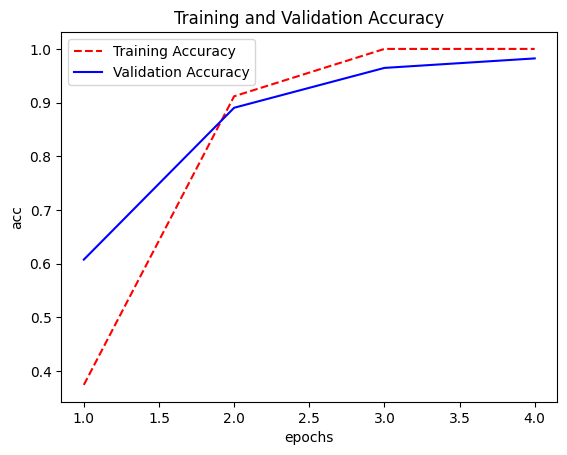

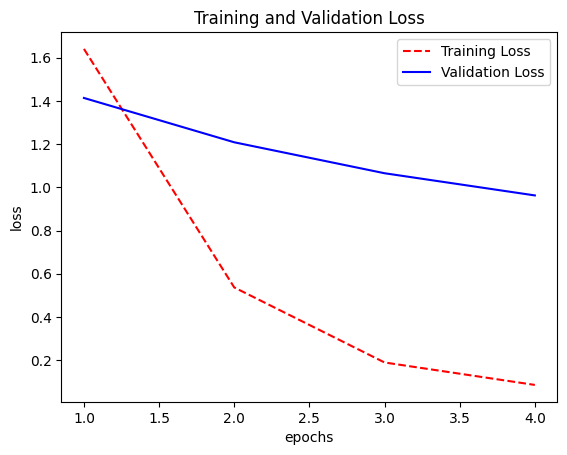

<Figure size 640x480 with 0 Axes>

In [79]:
val_loss = history.history['val_loss']
loss = history.history['loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1, 1)

plt.plot(epochs, acc, 'r--', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r--', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()

## 11 Model Testing

In [80]:
model.evaluate(x_test, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9806 - loss: 0.9535


[0.9531660676002502, 0.9834515452384949]

## 12 Saving Trained Model

In [81]:
'''filename = str(dt.datetime.today().strftime('%Y%m%d_%H%M'))
save_dir = '/content/' + filename

model_json = model.to_json()
with open (save_dir + '.json', 'w') as json_file:
  json_file.write('/content/' + model_json)

model.save(save_dir + '.h5') #'''

"filename = str(dt.datetime.today().strftime('%Y%m%d_%H%M'))\nsave_dir = '/content/' + filename\n\nmodel_json = model.to_json()\nwith open (save_dir + '.json', 'w') as json_file:\n  json_file.write('/content/' + model_json)\n\nmodel.save(save_dir + '.h5') #"

## 13 Checking The Result

### 13.01 Classification Report

In [82]:
y_predicted = np.argmax(model.predict(x_test), axis = -1)
cr = classification_report(y_test, y_predicted)

print('Classification Report\n', cr)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       102
           2       1.00      1.00      1.00        97
           3       0.94      1.00      0.97       106
           4       1.00      0.61      0.76        18

    accuracy                           0.98       423
   macro avg       0.99      0.92      0.95       423
weighted avg       0.98      0.98      0.98       423



### 13.02 Confusion Matrix

In [83]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[100,   0,   0,   0,   0],
       [  0, 102,   0,   0,   0],
       [  0,   0,  97,   0,   0],
       [  0,   0,   0, 106,   0],
       [  0,   0,   0,   7,  11]])

In [84]:
'''print('Confusion Matrix')
plt.figure(figsize = (5, 3))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() #'''

"print('Confusion Matrix')\nplt.figure(figsize = (5, 3))\nsns.heatmap(cm, annot = True, fmt = 'd')\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.show() #"

### 13.03 Prediction Table

In [85]:
test_label = []
predict_label = []
label_name =  []
predict_name = []
prediction_score = []

for i in range(0, x_test.shape[0]):
  test_label.append(y_test[i])
  t_label = rev_class_dict[y_test[i]]
  label_name.append(t_label)

  img = x_test[i]
  img = tf.expand_dims(img, axis = 0)
  prediction = model.predict(img)
  dense = prediction.reshape(-1).tolist()
  score = max(dense)
  index = dense.index(score)
  predict_label.append(index)

  p_label = rev_class_dict[index]
  predict_name.append(p_label)

  prediction_score.append(score)

prediction_result = pd.DataFrame({
  'label_num' : test_label,
  'label_name' : label_name,
  'predict_num' : predict_label,
  'predict_name' : predict_name,
  'predict_score' : prediction_score,
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━

In [86]:
prediction_result['pred_check'] = prediction_result['label_num'] == prediction_result['predict_num']
prediction_result.head()

,label_num,label_name,predict_num,predict_name,predict_score,pred_check
0,0,Healthy,0,Healthy,0.424959,True
1,1,Diabetes,1,Diabetes,0.432356,True
2,3,Anemia,3,Anemia,0.381592,True
3,1,Diabetes,1,Diabetes,0.393202,True
4,3,Anemia,3,Anemia,0.381592,True


### 13.04.F1 Score

In [87]:
labels = df[y_var].tolist()

f1_scores = f1_score(prediction_result['label_name'], prediction_result['predict_name'], average = None, labels = labels)
f1_dict = {label : score for label, score in zip(labels, f1_scores)}

f1_df = pd.DataFrame(list(f1_dict.items()), columns = ['class', 'f1_score'])
f1_df = f1_df.sort_values(by = 'f1_score', ascending = False).reset_index(drop = True)
f1_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,class,f1_score
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


<Axes: xlabel='f1_score', ylabel='class'>

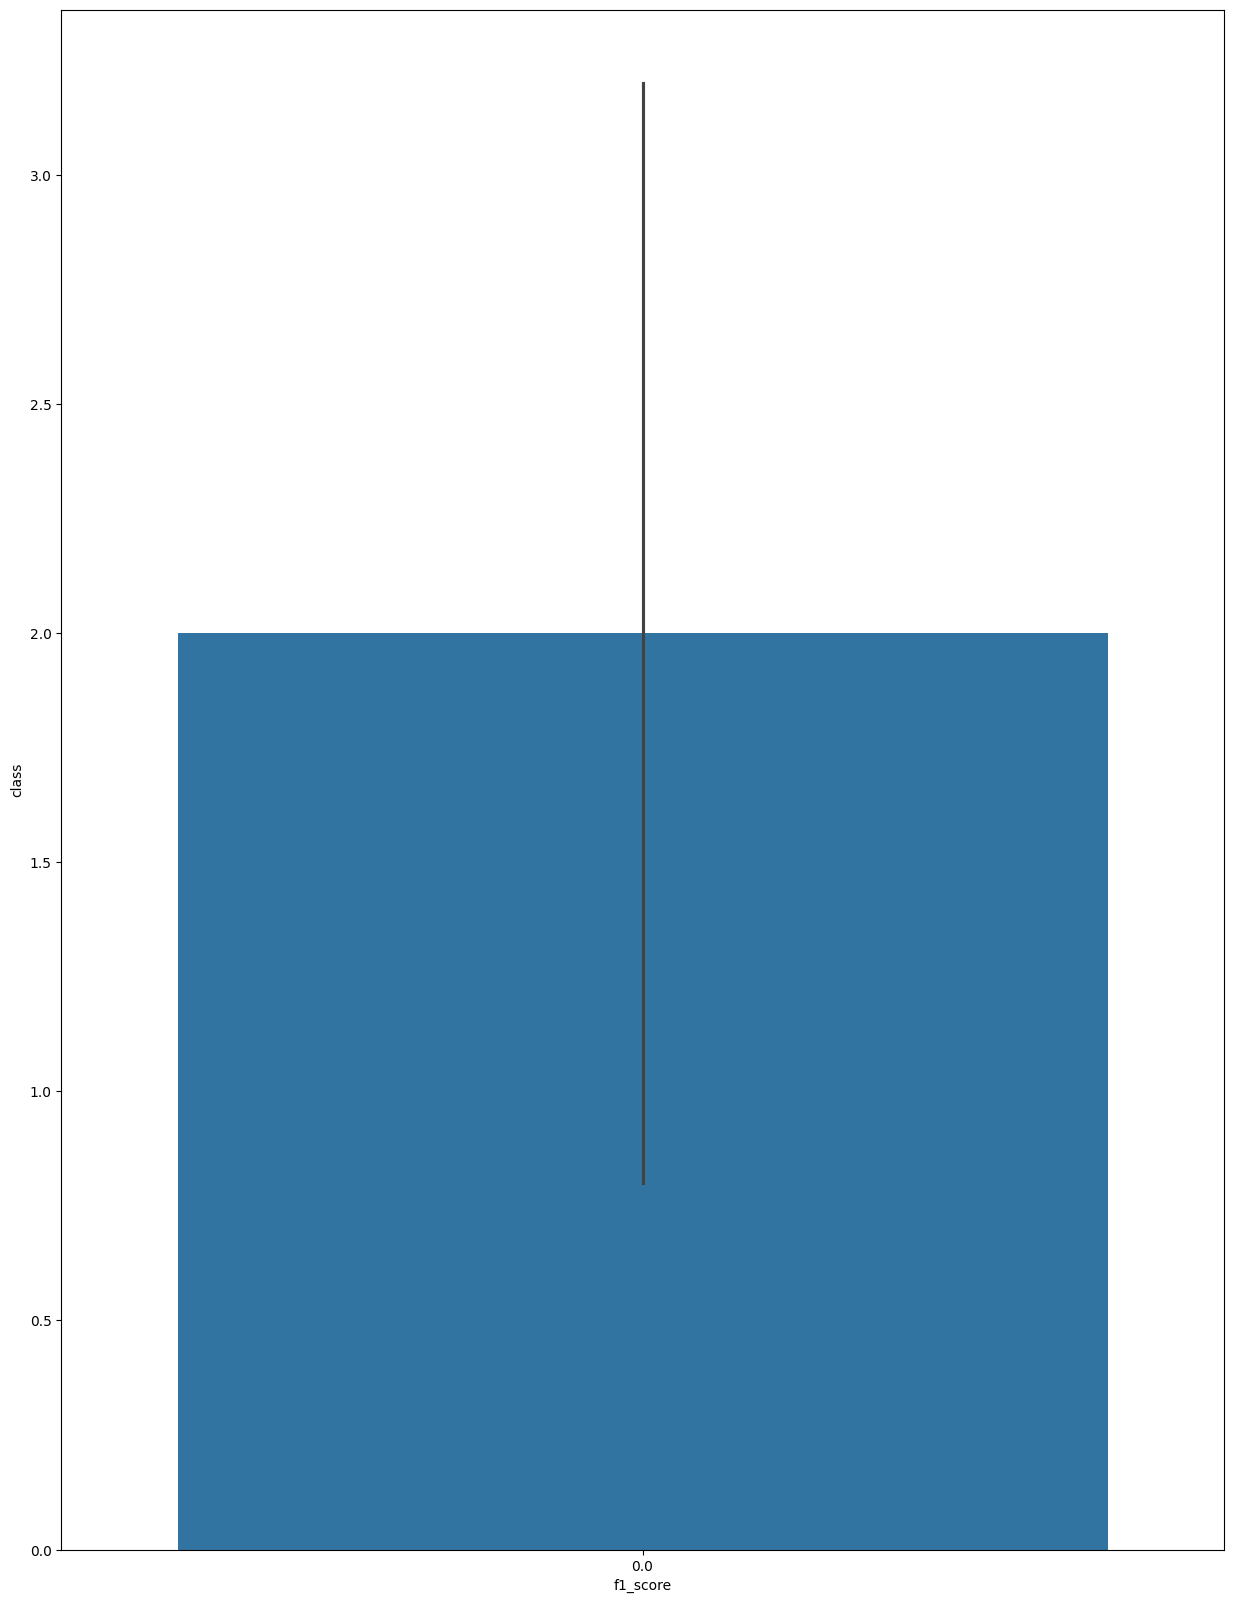

In [88]:
plt.figure(figsize = (15, 20), dpi = 100)
sns.barplot(x = f1_df['f1_score'], y = f1_df['class'])

### 13.05 False Prediction

In [89]:
false_pred = prediction_result[prediction_result['pred_check'] == False].sort_values('predict_score', ascending = False)
false_pred.head()

,label_num,label_name,predict_num,predict_name,predict_score,pred_check
6,4,Thromboc,3,Anemia,0.262042,False
49,4,Thromboc,3,Anemia,0.262042,False
156,4,Thromboc,3,Anemia,0.262042,False
196,4,Thromboc,3,Anemia,0.262042,False
205,4,Thromboc,3,Anemia,0.262042,False


In [91]:
false_pred.shape[0]

7